## データ読み込み

In [27]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import plotly.express as px
import pymc3 as pm
from scipy import stats

import pickle


In [28]:
dflist = []
for week in range(1, 8+1):
    dflist.append(pd.read_csv('../generated_data/model_week{}_v6.csv'.format(week)))
play_result = pd.concat(dflist)

## pymc coords用 idxの生成

In [29]:
all_rusher_nflId = list(play_result['Pass Rush_#1_nflId'].unique()) + list(play_result['Pass Rush_#2_nflId'].unique()) + \
                   list(play_result['Pass Rush_#3_nflId'].unique()) + list(play_result['Pass Rush_#4_nflId'].unique()) + \
                   list(play_result['Pass Rush_#5_nflId'].unique()) + list(play_result['Pass Rush_#6_nflId'].unique()) + \
                   list(play_result['Pass Rush_#7_nflId'].unique())
all_rusher_nflId = list(set(all_rusher_nflId))
all_blckr_nflId  = list(play_result['Pass Block_#1_nflId'].unique()) + list(play_result['Pass Block_#2_nflId'].unique()) + \
                   list(play_result['Pass Block_#3_nflId'].unique()) + list(play_result['Pass Block_#4_nflId'].unique()) + \
                   list(play_result['Pass Block_#5_nflId'].unique()) + list(play_result['Pass Block_#6_nflId'].unique()) + \
                   list(play_result['Pass Block_#7_nflId'].unique()) + list(play_result['Pass Block_#8_nflId'].unique()) + \
                   list(play_result['Pass Block_#9_nflId'].unique())
all_rusher_nflId = list(set(all_rusher_nflId))
all_blckr_nflId  = list(set(all_blckr_nflId))
rusher_nflId_df = pd.DataFrame({
    'rusher_nflId': all_rusher_nflId
})
blckr_nflId_df = pd.DataFrame({
    'blckr_nflId': all_blckr_nflId
})
rusher_nflId_df['rusher_nflId_idx'], rusher_nflId = pd.factorize(rusher_nflId_df['rusher_nflId'], sort=True)
blckr_nflId_df['blckr_nflId_idx'], blckr_nflId = pd.factorize(blckr_nflId_df['blckr_nflId'], sort=True)
for i in range(1, 7 + 1):
    play_result = pd.merge(
        play_result,
        rusher_nflId_df[['rusher_nflId','rusher_nflId_idx']].rename(columns={
            'rusher_nflId_idx': 'Pass Rush_#{}_nflId_idx'.format(i),
            'rusher_nflId': 'Pass Rush_#{}_nflId'.format(i)
        }),
        on='Pass Rush_#{}_nflId'.format(i),
        how='left'
    )
for i in range(1, 9+1):
    play_result = pd.merge(
        play_result,
        blckr_nflId_df[['blckr_nflId','blckr_nflId_idx']].rename(columns={
            'blckr_nflId_idx': 'Pass Block_#{}_nflId_idx'.format(i),
            'blckr_nflId': 'Pass Block_#{}_nflId'.format(i)
        }),
        on='Pass Block_#{}_nflId'.format(i),
        how='left'
    )
play_result['passer_nflId_idx'], passer_nflId = pd.factorize(play_result['Passer_nflId'], sort=True)
# play_result = play_result[play_result['is_pass_done'] == 1]
play_result.head(2)

,gameId,playId,is_pass_failed,passResult,playResult,playDescription,PassReceiver_nflId,PassReceiver_pff_role_num,PassReceiver_displayName,PassReceiver_short_name,...,Pass Block_#1_nflId_idx,Pass Block_#2_nflId_idx,Pass Block_#3_nflId_idx,Pass Block_#4_nflId_idx,Pass Block_#5_nflId_idx,Pass Block_#6_nflId_idx,Pass Block_#7_nflId_idx,Pass Block_#8_nflId_idx,Pass Block_#9_nflId_idx,passer_nflId_idx
0,2021090900,97,1,I,0,(13:33) (Shotgun) T.Brady pass incomplete deep...,44896,Pass Route_#5,Chris Godwin,C.Godwin,...,55,102,108,279,395,0,0,0,0,0
1,2021090900,137,0,C,28,(13:18) (Shotgun) D.Prescott pass deep left to...,42347,Pass Route_#1,Amari Cooper,A.Cooper,...,14,133,270,346,436,0,0,0,0,27


In [30]:
rusher_nflId_df.to_csv('../generated_data/for_animation_rusher_nflId_df.csv', index=False)
blckr_nflId_df.to_csv('../generated_data/for_animation_blckr_nflId_df.csv', index=False)

## 各プレーヤーのofficial positionを追加

In [31]:
players = pd.read_csv('../data/players.csv')
all_lineman_nflId = list(set(all_rusher_nflId + all_blckr_nflId))
rusher_players = players[players['nflId'].isin(all_rusher_nflId)]
rusher_players['position_idx'], rusher_position = pd.factorize(rusher_players['officialPosition'], sort=True)
blckr_players = players[players['nflId'].isin(all_blckr_nflId)]
blckr_players['position_idx'], blckr_position = pd.factorize(blckr_players['officialPosition'], sort=True)


for i in range(1, 7 + 1):
    play_result = pd.merge(
        play_result,
        rusher_players[['nflId','position_idx']].rename(columns={
            'nflId': 'Pass Rush_#{}_nflId'.format(i),
            'position_idx': 'Pass Rush_#{}_position_idx'.format(i)
        }),
        on='Pass Rush_#{}_nflId'.format(i),
        how='left'
    )
    play_result['Pass Rush_#{}_position_idx'.format(i)] = play_result['Pass Rush_#{}_position_idx'.format(i)].fillna(0)
    play_result['Pass Rush_#{}_position_idx'.format(i)] = play_result['Pass Rush_#{}_position_idx'.format(i)].astype(int)
for i in range(1, 9+1):
    play_result = pd.merge(
        play_result,
        blckr_players[['nflId','position_idx']].rename(columns={
            'nflId': 'Pass Block_#{}_nflId'.format(i),
            'position_idx': 'Pass Block_#{}_position_idx'.format(i),
        }),
        on='Pass Block_#{}_nflId'.format(i),
        how='left'
    )
    play_result['Pass Block_#{}_position_idx'.format(i)] = play_result['Pass Block_#{}_position_idx'.format(i)].fillna(0)
    play_result['Pass Block_#{}_position_idx'.format(i)] = play_result['Pass Block_#{}_position_idx'.format(i)].astype(int)
play_result.head(3)
play_result.to_csv('tmp_v6.csv', index=False)

## Pass failure explainable model

In [213]:
# from sklearn.model_selection import train_test_split


# dfTrain, dfTest = train_test_split(play_result, test_size=0.2, random_state=623)
# coords = {"passer_nflId": passer_nflId, 
#           'rusher_nflId': rusher_nflId, 
#           'blckr_nflId': blckr_nflId,
#           'rusher_position': rusher_position,
#           'blckr_position': blckr_position
#          }

# with pm.Model(coords=coords) as model:
#     passer_nflId_idx = pm.Data('passer_nflId_idx', dfTrain['passer_nflId_idx'])
#     data_PassReceiver_ttl_risk = pm.Data('PassReceiver_ttl_risk', dfTrain['PassReceiver_ttl_risk'])
#     rusher_dic = {}
#     for i in range(1, 7 + 1):
#         rusher_dic['rusher{}_nflId_idx'.format(i)] = pm.Data('rusher{}_nflId_idx'.format(i), dfTrain['Pass Rush_#{}_nflId_idx'.format(i)])
#         rusher_dic['rusher{}_impact'.format(i)] = pm.Data('rusher{}_impact'.format(i), dfTrain['Pass Rush_#{}_impact'.format(i)])
#         rusher_dic['rusher{}_height'.format(i)] = pm.Data('rusher{}_height'.format(i), dfTrain['Pass Rush_#{}_height_meter'.format(i)])
#         rusher_dic['rusher{}_weight'.format(i)] = pm.Data('rusher{}_weight'.format(i), dfTrain['Pass Rush_#{}_weight'.format(i)])
        
#     blckr_dic = {}
#     for i in range(1, 9 + 1):
#         blckr_dic['blckr{}_nflId_idx'.format(i)] = pm.Data('blckr{}_nflId_idx'.format(i), dfTrain['Pass Block_#{}_nflId_idx'.format(i)])
#         blckr_dic['blckr{}_impact'.format(i)] = pm.Data('blckr{}_impact'.format(i), dfTrain['Pass Block_#{}_impact'.format(i)])
#         blckr_dic['blckr{}_height'.format(i)] = pm.Data('blckr{}_height'.format(i), dfTrain['Pass Block_#{}_height_meter'.format(i)])
#         blckr_dic['blckr{}_weight'.format(i)] = pm.Data('blckr{}_weight'.format(i), dfTrain['Pass Block_#{}_weight'.format(i)])
        
#     # Define prior distribution
#     µ_passer_avg_skill = pm.Normal('µ_passer_avg_skill', mu=0, sigma=5)
#     σ_passer_avg_skill = pm.HalfCauchy("σ_passer_avg_skill", 3)
#     Δ_passer = pm.Normal('Δ_passer', 0.0, 5, dims='passer_nflId')
#     passer_skill = pm.Deterministic('passer_skill', 
#                                    µ_passer_avg_skill +  \
#                                    σ_passer_avg_skill * Δ_passer,
#                                    dims='passer_nflId')
#     coef_router_risk = pm.Normal('coef_router_risk', mu=0, sigma=10)

#     µ_rusher_avg_skill = pm.Normal('µ_rusher_avg_skill', mu=0, sigma=5)
#     σ_rusher_avg_skill = pm.HalfCauchy("σ_rusher_avg_skill", 3)
#     Δ_rusher = pm.Normal('Δ_rusher', 0.0, 5, dims='rusher_nflId')
#     rusher_skill = pm.Deterministic('rusher_skill', 
#                                    µ_rusher_avg_skill +  \
#                                    σ_rusher_avg_skill * Δ_rusher,
#                                    dims='rusher_nflId')
    
#     µ_blckr_avg_skill = pm.Normal('µ_blckr_avg_skill', mu=0, sigma=5)
#     σ_blckr_avg_skill = pm.HalfCauchy("σ_blckr_avg_skill", 3)
#     Δ_blckr = pm.Normal('Δ_blckr', 0.0, 5, dims='blckr_nflId')
#     blckr_skill = pm.Deterministic('blckr_skill', 
#                                    µ_blckr_avg_skill +  \
#                                    σ_blckr_avg_skill * Δ_blckr,
#                                    dims='blckr_nflId')
    
#     # Define equation
#     logit_p = coef_router_risk * data_PassReceiver_ttl_risk + \
#               passer_skill[passer_nflId_idx]
#     for i in range(1, 7 + 1):
#         logit_p += rusher_dic['rusher{}_impact'.format(i)] * (
#             rusher_skill[rusher_dic['rusher{}_nflId_idx'.format(i)]] + \
#             rusher_dic['rusher{}_height'.format(i)] + rusher_dic['rusher{}_weight'.format(i)]
#         )
#     for i in range(1, 9 + 1):
#         logit_p -= blckr_dic['blckr{}_impact'.format(i)] * (
#             blckr_skill[blckr_dic['blckr{}_nflId_idx'.format(i)]] + \
#             blckr_dic['blckr{}_height'.format(i)] + blckr_dic['blckr{}_weight'.format(i)]
#         )
#     pass_fail = pm.Bernoulli(
#         'pass_fail',
#         logit_p=logit_p,
#         observed=dfTrain['is_pass_failed'].values,
#     )
# with model:
#     model_trace = pm.sample(1000, tune=100, return_inferencedata=True, target_accept=.95)


In [214]:
from sklearn.model_selection import train_test_split


dfTrain, dfTest = train_test_split(play_result, test_size=0.2, random_state=623)
coords = {"passer_nflId": passer_nflId, 
          'rusher_nflId': rusher_nflId, 
          'blckr_nflId': blckr_nflId,
          'rusher_position': rusher_position,
          'blckr_position': blckr_position
         }

with pm.Model(coords=coords) as model:
    passer_nflId_idx = pm.Data('passer_nflId_idx', dfTrain['passer_nflId_idx'])
    data_PassReceiver_ttl_risk = pm.Data('PassReceiver_ttl_risk', dfTrain['PassReceiver_ttl_risk'])
    rusher_dic = {}
    for i in range(1, 7 + 1):
        rusher_dic['rusher{}_impact'.format(i)] = pm.Data('rusher{}_impact'.format(i), dfTrain['Pass Rush_#{}_impact'.format(i)])
        
    blckr_dic = {}
    for i in range(1, 9 + 1):
        blckr_dic['blckr{}_impact'.format(i)] = pm.Data('blckr{}_impact'.format(i), dfTrain['Pass Block_#{}_impact'.format(i)])
        
    # Define prior distribution
    µ_passer_avg_skill = pm.Normal('µ_passer_avg_skill', mu=0, sigma=5)
    σ_passer_avg_skill = pm.HalfCauchy("σ_passer_avg_skill", 3)
    Δ_passer = pm.Normal('Δ_passer', 0.0, 5, dims='passer_nflId')
    passer_skill = pm.Deterministic('passer_skill', 
                                   µ_passer_avg_skill +  \
                                   σ_passer_avg_skill * Δ_passer,
                                   dims='passer_nflId')
    coef_router_risk = pm.Normal('coef_router_risk', mu=0, sigma=10)
    
    coef_rusher = pm.Normal('coef_rusher', mu=0, sigma=100)
    coef_blckr = pm.Normal('coef_blckr', mu=0, sigma=100)
    
    # Define equation
    logit_p = coef_router_risk * data_PassReceiver_ttl_risk + \
              passer_skill[passer_nflId_idx]
    for i in range(1, 7 + 1):
        logit_p += rusher_dic['rusher{}_impact'.format(i)] * coef_rusher
    for i in range(1, 9 + 1):
        logit_p -= blckr_dic['blckr{}_impact'.format(i)] * coef_blckr
    pass_fail = pm.Bernoulli(
        'pass_fail',
        logit_p=logit_p,
        observed=dfTrain['is_pass_failed'].values,
    )
with model:
    model_trace = pm.sample(1000, tune=100, return_inferencedata=True, target_accept=.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef_blckr, coef_rusher, coef_router_risk, Δ_passer, σ_passer_avg_skill, µ_passer_avg_skill]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 456 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [215]:
import pickle

with open('model_v6.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('model_trace_v6.pkl', 'wb') as f:
    pickle.dump(model_trace, f)

array([[<AxesSubplot:title={'center':'passer_skill'}>,
        <AxesSubplot:title={'center':'passer_skill'}>]], dtype=object)

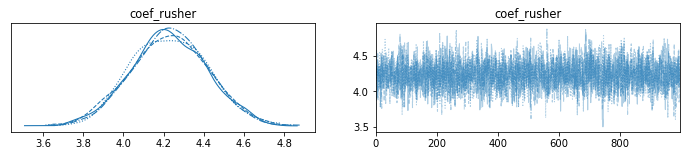

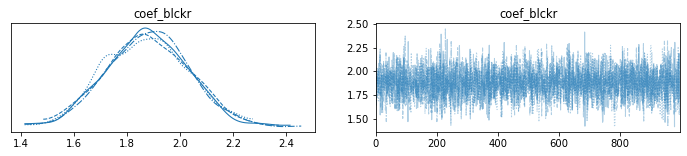

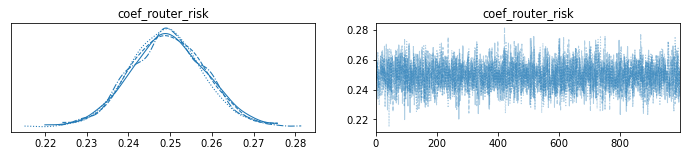

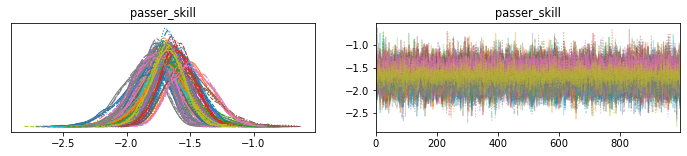

In [216]:
pm.plot_trace(model_trace, var_names='coef_rusher')
pm.plot_trace(model_trace, var_names='coef_blckr')
pm.plot_trace(model_trace, var_names='coef_router_risk')
pm.plot_trace(model_trace, var_names='passer_skill')

# Performance visualization
## Prediction with test data


In [217]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score


# with model:
#     pm.set_data({'passer_nflId_idx': dfTest['passer_nflId_idx']})
#     pm.set_data({'PassReceiver_ttl_risk': dfTest['PassReceiver_ttl_risk']})
#     for i in range(1, 7 + 1):
#         pm.set_data({'rusher{}_nflId_idx'.format(i): dfTest['Pass Rush_#{}_nflId_idx'.format(i)]})
#         pm.set_data({'rusher{}_impact'.format(i): dfTest['Pass Rush_#{}_impact'.format(i)]})
#         pm.set_data({'rusher{}_height'.format(i): dfTest['Pass Rush_#{}_height_meter'.format(i)]})
#         pm.set_data({'rusher{}_weight'.format(i): dfTest['Pass Rush_#{}_weight'.format(i)]})
# #         pm.set_data({'rusher{}_position_idx'.format(i): dfTest['Pass Rush_#{}_position_idx'.format(i)]})
#     for i in range(1, 9 + 1):
#         pm.set_data({'blckr{}_nflId_idx'.format(i): dfTest['Pass Block_#{}_nflId_idx'.format(i)]})
#         pm.set_data({'blckr{}_impact'.format(i): dfTest['Pass Block_#{}_impact'.format(i)]})
#         pm.set_data({'blckr{}_height'.format(i): dfTest['Pass Block_#{}_height_meter'.format(i)]})
#         pm.set_data({'blckr{}_weight'.format(i): dfTest['Pass Block_#{}_weight'.format(i)]})
# #         pm.set_data({'blckr{}_position_idx'.format(i): dfTest['Pass Block_#{}_position_idx'.format(i)]})
#     posterior = pm.sample_posterior_predictive(model_trace)
# dfTest_res = dfTest
# dfTest_res['pred'] = posterior['pass_fail'].mean(axis=0)
# dfTest_res['pred_is_failed'] = (dfTest_res['pred'] > 0.5).astype(int)

# cm = confusion_matrix(dfTest_res['is_pass_failed'], dfTest_res['pred_is_failed'])
# print('confusion matrix')
# print(cm)
# print('precision_score')
# print(precision_score(dfTest_res['is_pass_failed'], dfTest_res['pred_is_failed']))
# print('recall_score')
# print(recall_score(dfTest_res['is_pass_failed'], dfTest_res['pred_is_failed']))


In [218]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


with model:
    pm.set_data({'passer_nflId_idx': dfTest['passer_nflId_idx']})
    pm.set_data({'PassReceiver_ttl_risk': dfTest['PassReceiver_ttl_risk']})
    for i in range(1, 7 + 1):
        pm.set_data({'rusher{}_impact'.format(i): dfTest['Pass Rush_#{}_impact'.format(i)]})
    for i in range(1, 9 + 1):
        pm.set_data({'blckr{}_impact'.format(i): dfTest['Pass Block_#{}_impact'.format(i)]})
    posterior = pm.sample_posterior_predictive(model_trace)
dfTest_res = dfTest
dfTest_res['pred'] = posterior['pass_fail'].mean(axis=0)
dfTest_res['pred_is_failed'] = (dfTest_res['pred'] > 0.5).astype(int)

cm = confusion_matrix(dfTest_res['is_pass_failed'], dfTest_res['pred_is_failed'])
print('confusion matrix')
print(cm)
print('precision_score')
print(precision_score(dfTest_res['is_pass_failed'], dfTest_res['pred_is_failed']))
print('recall_score')
print(recall_score(dfTest_res['is_pass_failed'], dfTest_res['pred_is_failed']))


confusion matrix
[[730 148]
 [251 360]]
precision_score
0.7086614173228346
recall_score
0.5891980360065466


In [219]:
with model:
    pm.set_data({'passer_nflId_idx': dfTrain['passer_nflId_idx']})
    pm.set_data({'PassReceiver_ttl_risk': dfTrain['PassReceiver_ttl_risk']})
    for i in range(1, 7 + 1):
        pm.set_data({'rusher{}_impact'.format(i): dfTrain['Pass Rush_#{}_impact'.format(i)]})
    for i in range(1, 9 + 1):
        pm.set_data({'blckr{}_impact'.format(i): dfTrain['Pass Block_#{}_impact'.format(i)]})
    posterior = pm.sample_posterior_predictive(model_trace)
dfTrain_res = dfTrain
dfTrain_res['pred'] = posterior['pass_fail'].mean(axis=0)
dfTrain_res['pred_is_failed'] = (dfTrain_res['pred'] > 0.5).astype(int)

cm = confusion_matrix(dfTrain_res['is_pass_failed'], dfTrain_res['pred_is_failed'])
print('confusion matrix')
print(cm)
print('precision_score')
print(precision_score(dfTrain_res['is_pass_failed'], dfTrain_res['pred_is_failed']))
print('recall_score')
print(recall_score(dfTrain_res['is_pass_failed'], dfTrain_res['pred_is_failed']))


confusion matrix
[[2962  497]
 [ 978 1518]]
precision_score
0.753349875930521
recall_score
0.6081730769230769


In [220]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(dfTrain_res['is_pass_failed'], dfTrain_res['pred'])
print('Train data result', auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(dfTest_res['is_pass_failed'], dfTest_res['pred'])
print('Test data result',auc(fpr, tpr))


Train data result 0.8328120598624176
Test data result 0.813058058599182


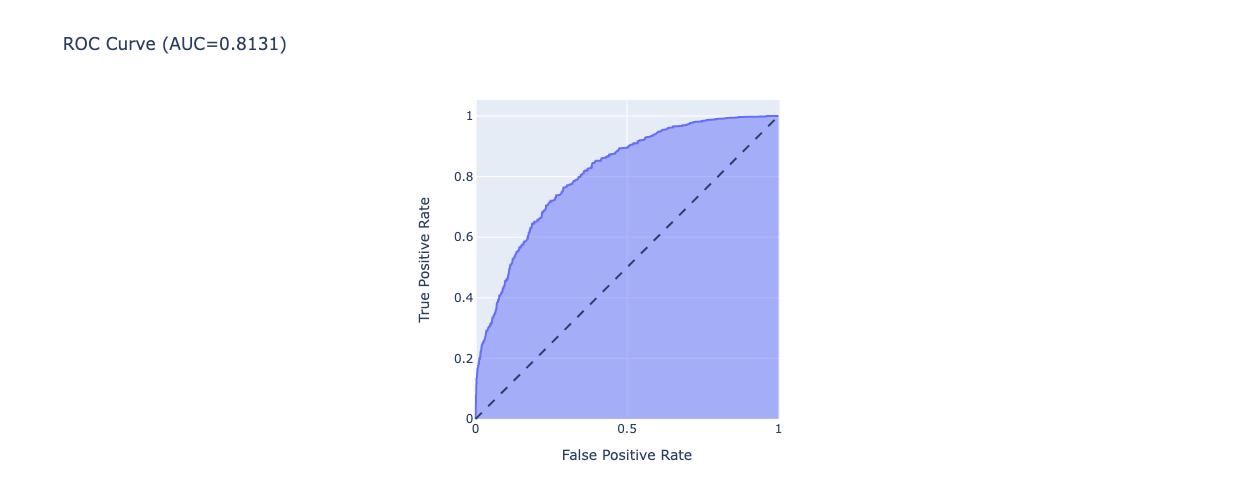

In [221]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(dfTest_res['is_pass_failed'], dfTest_res['pred'])
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [222]:
dfTrain_res.to_csv('dfTrain_res.csv', index=False)
dfTest_res.to_csv('dfTest_res.csv', index=False)

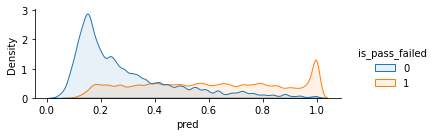

In [223]:
sns.displot(data=dfTrain_res,
            x='pred',
            kind='kde',
            hue='is_pass_failed',
            fill=True,
            alpha=0.1,
            height=2,
            aspect=2.5,
            bw_method=0.05
)

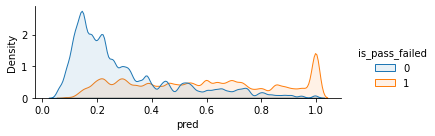

In [224]:
sns.displot(data=dfTest_res,
            x='pred',
            kind='kde',
            hue='is_pass_failed',
            fill=True,
            alpha=0.1,
            height=2,
            aspect=2.5,
            bw_method=0.05
)

In [225]:
print(
    len(dfTrain),
    len(dfTest),
    len(dfTrain) + len(dfTest)
)
summary = pm.summary(model_trace).reset_index()


5955 1489 7444


# ラッシャーの能力評価モデル

In [6]:
import pickle

with open('model_v6_for_animation.pkl', 'rb') as f:
#     pickle.dump(model, f)
    model = pickle.load(f)
with open('model_trace_v6_for_animation.pkl', 'rb') as f:
#     pickle.dump(model_trace, f)
    model_trace = pickle.load(f)

summary = pm.summary(model_trace).reset_index()
coef_rusher = summary[summary['index'].str.contains('coef_rusher')]['mean'].values[0]
coef_blckr = summary[summary['index'].str.contains('coef_blckr')]['mean'].values[0]


In [7]:
rusher_list = [
    'Pass Rush_#1_dist_blckr_avg','Pass Rush_#2_dist_blckr_avg',
    'Pass Rush_#3_dist_blckr_avg','Pass Rush_#4_dist_blckr_avg',
    'Pass Rush_#5_dist_blckr_avg','Pass Rush_#6_dist_blckr_avg',
    'Pass Rush_#7_dist_blckr_avg'
]
rusher_box_list = []
for i in range(1, 8+1):
    tmp = pd.read_csv('../generated_data/rshr_to_blckr_week{}_v6.csv'.format(i))
    
    
    tmp = tmp.groupby(['gameId','playId'])[rusher_list].mean().reset_index()
    rusher_box_list.append(tmp)
rusher_box = pd.concat(rusher_box_list)
rusher_box.head(3)

impct_list = [
    'Pass Rush_#1_impact','Pass Rush_#2_impact',
    'Pass Rush_#3_impact','Pass Rush_#4_impact',
    'Pass Rush_#5_impact','Pass Rush_#6_impact',
    'Pass Rush_#7_impact'
]

play_result['gameId'] = play_result['gameId'].astype(int)
play_result['playId'] = play_result['playId'].astype(int)
rusher_box['gameId'] = rusher_box['gameId'].astype(int)
rusher_box['playId'] = rusher_box['playId'].astype(int)

for col in impct_list:
    new_col = col.split('_impact')[0]
    play_result[new_col + '_threat'] = play_result[col] * coef_rusher
play_result2 = pd.merge(
    play_result,
    rusher_box,
    on=['gameId','playId'],
    how='left'
)
play_result2.head(3)

,gameId,playId,is_pass_failed,passResult,playResult,playDescription,PassReceiver_nflId,PassReceiver_pff_role_num,PassReceiver_displayName,PassReceiver_short_name,...,Pass Rush_#5_threat,Pass Rush_#6_threat,Pass Rush_#7_threat,Pass Rush_#1_dist_blckr_avg,Pass Rush_#2_dist_blckr_avg,Pass Rush_#3_dist_blckr_avg,Pass Rush_#4_dist_blckr_avg,Pass Rush_#5_dist_blckr_avg,Pass Rush_#6_dist_blckr_avg,Pass Rush_#7_dist_blckr_avg
0,2021090900,97,1,I,0,(13:33) (Shotgun) T.Brady pass incomplete deep...,44896,Pass Route_#5,Chris Godwin,C.Godwin,...,0.566169,0.0,0.0,0.606859,0.551935,0.484804,0.582329,0.754246,NaN,NaN
1,2021090900,137,0,C,28,(13:18) (Shotgun) D.Prescott pass deep left to...,42347,Pass Route_#1,Amari Cooper,A.Cooper,...,0.140157,0.0,0.0,0.714959,0.657198,0.493414,0.520459,0.591649,NaN,NaN
2,2021090900,187,0,C,5,(12:23) (Shotgun) D.Prescott pass short middle...,46206,Pass Route_#4,Dalton Schultz,D.Schultz,...,0.000000,0.0,0.0,0.867357,0.528795,0.879871,0.728345,NaN,NaN,NaN


In [228]:

rusher_box_agg_list = []
for i in range(1, 8+1):
    rusher_box_agg_list.append(
#         pd.read_csv('../generated_data/blckr_impct_to_rshr{}_v6.csv'.format(i))
        pd.read_csv('../generated_data/blckr_impct_to_rshr{}_firstHalf_v6.csv'.format(i))
    )
# rusher_box_agg = pd.read_csv('../generated_data/blckr_impct_to_rshr1_v6.csv')
rusher_box_agg = pd.concat(rusher_box_agg_list)
rusher_box_agg.head(3)

rusher_skill_df_list = []
for i in range(1, 7 + 1):
    col = [
        'gameId',
        'playId',
        'is_pass_failed',
        'Pass Rush_#{}_nflId'.format(i), 
        'Pass Rush_#{}_threat'.format(i)
    ]
    tmp = play_result2[col].rename(columns={
        'Pass Rush_#{}_nflId'.format(i): 'Pass Rush_nflId',
        'Pass Rush_#{}_threat'.format(i): 'Pass Rush_threat'
    })
    rusher_skill_df_list.append(tmp)
rusher_skill_df = pd.concat(rusher_skill_df_list)
rusher_skill_df.head()
print(len(rusher_skill_df))
rusher_skill_df.head()
rusher_skill_df = pd.merge(
    rusher_skill_df,
    rusher_box_agg,
    on=['gameId','playId','Pass Rush_nflId'],
    how='left'
)
# Null除去
rusher_skill_df = rusher_skill_df.dropna()
print(len(rusher_skill_df))
# イレギュラーの除去
rusher_skill_df=rusher_skill_df[rusher_skill_df['Pass Rush_nflId'] > 0]
print(len(rusher_skill_df))

# Nプレー以上のプレイヤーのみで抽出
plycnt = rusher_skill_df.groupby('Pass Rush_nflId')[['playId']].count().reset_index().rename(columns={'playId': 'plycnt'})
plycnt = plycnt[plycnt['plycnt'] >= 50]
rusher_skill_df = rusher_skill_df[rusher_skill_df['Pass Rush_nflId'].isin(plycnt['Pass Rush_nflId'])]
print(len(rusher_skill_df))

rusher_skill_df.to_csv('./rshr2blckr_dist.csv', index=False)

52108
52108
31637
25969


In [229]:
rusher_skill_df['Pass Rush_nflId_idx'], rusher_nflId = pd.factorize(rusher_skill_df['Pass Rush_nflId'], sort=True)
coords = {'rusher_nflId': rusher_nflId}

with pm.Model(coords=coords) as model_rusher_ability:
    rusher_nflId_idx = pm.Data('rusher_nflId_idx', rusher_skill_df['Pass Rush_nflId_idx'])
    blckr_threat = pm.Data('blckr_threat',rusher_skill_df['blockers_ttl_impact_to_rusher_mean'])
    coef_blckr_threat = pm.HalfCauchy('coef_blckr_threat', 2)
    µ_rusher_avg_ability = pm.Normal('µ_rusher_avg_ability', mu=0, sigma=3)
    σ_rusher_avg_ability = pm.HalfCauchy("σ_rusher_avg_ability", 1)
    Δ_rusher = pm.Normal('Δ_rusher', 0.0, 3, dims='rusher_nflId')
    rusher_ability = pm.Deterministic(
        'rusher_ability', 
        µ_rusher_avg_ability +  \
        σ_rusher_avg_ability * Δ_rusher,
        dims='rusher_nflId'
    )
    σ_rusher_threat = pm.HalfCauchy("σ_rusher_threat", 1)
    rusher_threat = pm.Normal(
        'rusher_threat',
        mu=rusher_ability[rusher_nflId_idx] - (coef_blckr_threat * blckr_threat),
        sigma=σ_rusher_threat,
        observed=rusher_skill_df['Pass Rush_threat'].values,
    )
with model_rusher_ability:
#     model_rusher_ability_trace = pm.sample(500, tune=50, return_inferencedata=True, target_accept=.95)
    model_rusher_ability_trace = pm.sample(1000, tune=100, return_inferencedata=True, target_accept=.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_rusher_threat, Δ_rusher, σ_rusher_avg_ability, µ_rusher_avg_ability, coef_blckr_threat]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 867 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [230]:
import pickle

with open('model_rusher_ability_v6.pkl', 'wb') as f:
    pickle.dump(model_rusher_ability, f)
with open('model_rusher_ability_trace_v6.pkl', 'wb') as f:
    pickle.dump(model_rusher_ability_trace, f)

array([[<AxesSubplot:title={'center':'rusher_ability'}>,
        <AxesSubplot:title={'center':'rusher_ability'}>]], dtype=object)

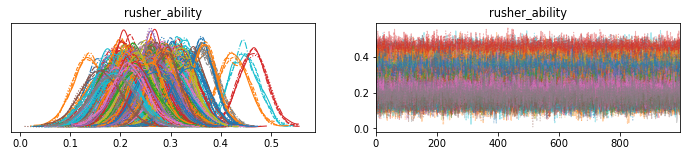

In [231]:
# pm.traceplot(model_rusher_skill_trace)
pm.plot_trace(model_rusher_ability_trace, var_names='rusher_ability')

# ラッシャー能力値と実績の相関分析

In [232]:
rush_pff_scouting = pd.read_csv('../data/pffScoutingData_with_name.csv')
rush_pff_scouting = rush_pff_scouting[rush_pff_scouting['pff_role']=='Pass Rush']
rush_pff_scouting = rush_pff_scouting.groupby('nflId')[['pff_hit','pff_hurry','pff_sack']].sum().reset_index().rename(columns={
    'pff_hit': 'sum_pff_hit',
    'pff_hurry': 'sum_pff_hurry',
    'pff_sack': 'sum_pff_sack'
})
rush_players = pd.read_csv('../generated_data/rush_players_v6.csv')
rusher_ability_summary = pm.summary(model_rusher_ability_trace).reset_index()

In [233]:
rushers = rusher_ability_summary[rusher_ability_summary['index'].str.contains('rusher_ability')].sort_values(by='mean', ascending=False)
rushers['nflId'] = rushers['index'].str.split('[', expand=True)[1].str.split(']', expand=True)[0]
rushers['nflId'] = rushers['nflId'].astype(int)
rushers['rusher_ability'] = rushers['mean']
rushers = pd.merge(
    rushers[['nflId','rusher_ability']],
    rush_players[['nflId','height','weight','birthDate',
                  'collegeName','officialPosition','displayName',
                  'play_cnt']],
    on='nflId',
    how='left'
)
rushers = pd.merge(
    rushers,
    rush_pff_scouting,
    on='nflId',
    how='left'
)
rushers = pd.merge(
    rushers,
    rusher_skill_df.groupby('Pass Rush_nflId')[['blockers_ttl_impact_to_rusher_mean','is_pass_failed']].mean().reset_index().rename(
        columns={'Pass Rush_nflId': 'nflId', 
                 'blockers_ttl_impact_to_rusher_mean': 'blockers_avg_impact',
                 'is_pass_failed': 'pass_failure_prob'}
    ),
    on='nflId',
    how='left'
)
rushers.head()

,nflId,rusher_ability,height,weight,birthDate,collegeName,officialPosition,displayName,play_cnt,sum_pff_hit,sum_pff_hurry,sum_pff_sack,blockers_avg_impact,pass_failure_prob
0,44813,0.464,6-4,0.548077,1995-12-29,Texas A&amp;M,DE,Myles Garrett,208,9.0,29.0,12.0,0.299861,0.502959
1,43326,0.446,6-6,0.721154,1994-07-03,Mississippi State,DT,Chris Jones,151,3.0,18.0,3.0,0.600194,0.540881
2,43378,0.425,6-2,0.706731,1993-02-07,South Carolina State,DT,Javon Hargrave,172,6.0,15.0,5.0,0.952536,0.407643
3,35539,0.368,6-3,0.552885,1987-12-22,Southern California,DE,Everson Griffen,168,5.0,16.0,5.0,0.331763,0.533333
4,47889,0.366,6-5,0.466346,1997-08-22,Eastern Michigan,DE,Maxx Crosby,218,12.0,30.0,7.0,0.306165,0.427027


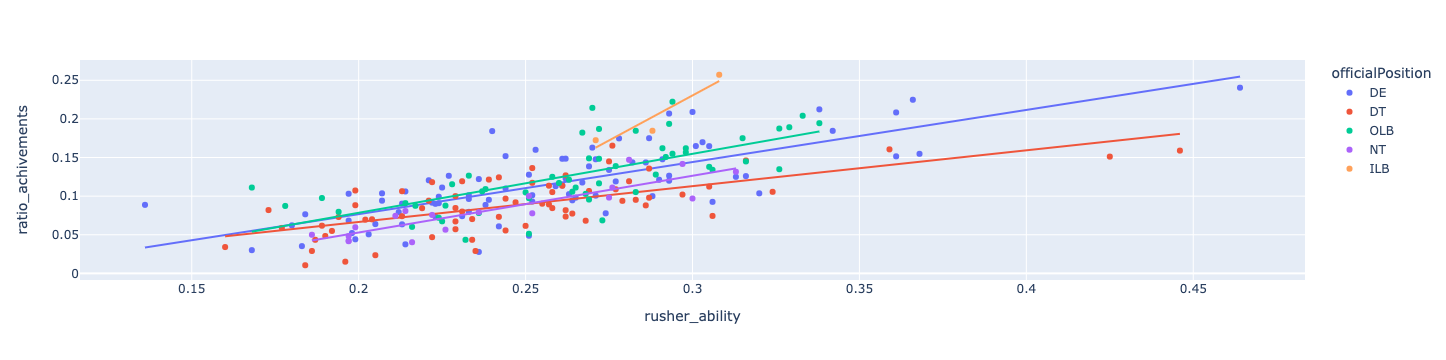

In [234]:
rushers['sum_achivements'] = rushers[['sum_pff_hit','sum_pff_hurry','sum_pff_sack']].sum(axis=1)
rushers['ratio_achivements'] = rushers['sum_achivements'] / rushers['play_cnt']

px.scatter(rushers, x='rusher_ability', y='ratio_achivements', color='officialPosition', trendline="ols")

In [235]:
rushers.to_csv('hoge.csv', index=False)

In [236]:
rushers[(rushers['officialPosition']=='DT') & (rushers['play_cnt'] >= 180)].sort_values(by='rusher_ability', ascending=False)

,nflId,rusher_ability,height,weight,birthDate,collegeName,officialPosition,displayName,play_cnt,sum_pff_hit,sum_pff_hurry,sum_pff_sack,blockers_avg_impact,pass_failure_prob,sum_achivements,ratio_achivements
7,44829,0.359,6-3,0.682692,1995-01-16,Alabama,DT,Jonathan Allen,218,8.0,21.0,6.0,0.895671,0.402062,35.0,0.160550
17,41239,0.316,6-1,0.586538,1991-05-23,Pittsburgh,DT,Aaron Donald,260,8.0,24.0,6.0,0.734550,0.418103,38.0,0.146154
52,37104,0.287,6-5,0.658654,1989-05-06,Ohio State,DT,Cameron Heyward,199,2.0,22.0,3.0,0.736129,0.389831,27.0,0.135678
53,42349,0.287,6-5,0.692308,1994-06-20,Southern California,DT,Leonard Williams,245,4.0,14.0,6.0,0.750903,0.395238,24.0,0.097959
60,43296,0.281,6-7,0.682692,1994-03-17,Oregon,DT,DeForest Buckner,218,4.0,18.0,4.0,0.803641,0.350785,26.0,0.119266
62,44877,0.279,6-3,0.706731,1994-06-03,North Carolina-Charlotte,DT,Larry Ogunjobi,213,2.0,14.0,4.0,0.804367,0.406417,20.0,0.093897
97,47802,0.262,6-4,0.682692,1997-07-28,Mississippi State,DT,Jeffery Simmons,268,4.0,26.0,4.0,0.821733,0.463203,34.0,0.126866
104,38667,0.261,6-5,0.634615,1990-01-11,Tennessee,DT,Malik Jackson,194,5.0,16.0,1.0,0.731835,0.477707,22.0,0.113402
111,42480,0.257,6-0,0.706731,1993-04-28,Clemson,DT,Grady Jarrett,185,2.0,18.0,1.0,0.846665,0.430380,21.0,0.113514
131,53467,0.242,6-5,0.730769,NaN,NaN,DT,Christian Barmore,185,5.0,17.0,1.0,0.827424,0.418750,23.0,0.124324


In [237]:
rushers[(rushers['officialPosition']=='DE') & (rushers['play_cnt'] >= 180)].sort_values(by='rusher_ability', ascending=False)

,nflId,rusher_ability,height,weight,birthDate,collegeName,officialPosition,displayName,play_cnt,sum_pff_hit,sum_pff_hurry,sum_pff_sack,blockers_avg_impact,pass_failure_prob,sum_achivements,ratio_achivements
0,44813,0.464,6-4,0.548077,1995-12-29,Texas A&amp;M,DE,Myles Garrett,208,9.0,29.0,12.0,0.299861,0.502959,50.0,0.240385
4,47889,0.366,6-5,0.466346,1997-08-22,Eastern Michigan,DE,Maxx Crosby,218,12.0,30.0,7.0,0.306165,0.427027,49.0,0.224771
5,43358,0.361,6-2,0.423077,1995-03-31,Maryland,DE,Yannick Ngakoue,198,6.0,20.0,4.0,0.310384,0.402367,30.0,0.151515
6,44915,0.361,6-4,0.538462,1994-12-05,Florida Atlantic,DE,Trey Hendrickson,216,6.0,29.0,10.0,0.316563,0.422460,45.0,0.208333
16,47854,0.320,6-3,0.591346,1997-01-05,Ohio State,DE,Dre'Mont Jones,193,3.0,15.0,2.0,0.778709,0.465517,20.0,0.103627
30,42031,0.303,6-5,0.610577,1990-07-15,Mississippi State,DE,Denico Autry,212,7.0,24.0,5.0,0.532116,0.472826,36.0,0.169811
51,42431,0.287,6-5,0.451923,1994-10-29,Louisiana State,DE,Danielle Hunter,200,3.0,26.0,6.0,0.259593,0.483146,35.0,0.175000
54,37084,0.286,6-5,0.625000,1989-03-22,Wisconsin,DE,J.J. Watt,188,11.0,15.0,1.0,0.704598,0.422360,27.0,0.143617
89,47809,0.267,6-6,0.500000,1996-09-04,Mississippi State,DE,Montez Sweat,221,7.0,15.0,4.0,0.262150,0.395939,26.0,0.117647
101,47799,0.262,6-5,0.442308,1998-04-23,Florida State,DE,Brian Burns,202,5.0,20.0,5.0,0.246166,0.469274,30.0,0.148515


In [238]:
rushers[(rushers['officialPosition']=='OLB') & (rushers['play_cnt'] >= 180)].sort_values(by='rusher_ability', ascending=False)

,nflId,rusher_ability,height,weight,birthDate,collegeName,officialPosition,displayName,play_cnt,sum_pff_hit,sum_pff_hurry,sum_pff_sack,blockers_avg_impact,pass_failure_prob,sum_achivements,ratio_achivements
11,47795,0.333,6-5,0.572115,1997-12-03,Michigan,OLB,Rashan Gary,196,10.0,25.0,5.0,0.213369,0.439759,40.0,0.204082
12,41915,0.329,6-2,0.442308,1992-11-17,Colorado State,OLB,Shaquil Barrett,222,7.0,29.0,6.0,0.270522,0.456853,42.0,0.189189
20,43298,0.315,6-5,0.394231,1992-09-08,Georgia,OLB,Leonard Floyd,200,2.0,25.0,8.0,0.171085,0.439560,35.0,0.175000
38,43435,0.294,6-3,0.495192,1992-08-15,Grand Valley State,OLB,Matt Judon,189,7.0,26.0,9.0,0.270765,0.465409,42.0,0.222222
88,46110,0.267,6-2,0.442308,1996-06-05,Boston College,OLB,Harold Landry,225,7.0,26.0,8.0,0.234725,0.478947,41.0,0.182222
105,44825,0.260,6-1,0.370192,1994-09-22,Temple,OLB,Haason Reddick,188,3.0,11.0,8.0,0.229977,0.447853,22.0,0.117021
182,48089,0.214,6-2,0.370192,1996-08-05,Nevada,OLB,Malik Reed,198,3.0,11.0,4.0,0.132665,0.497175,18.0,0.090909


# ブロッカー貢献度の計算

In [16]:
blckr_assgn_list = []
for week in range(1, 8 + 1):
    blckr_assgn_list.append(pd.read_csv('../generated_data/blckr_contribution{}_v6.csv'.format(week)))
blckr_assgn = pd.concat(blckr_assgn_list)
blckr_assgn = pd.merge(
    blckr_assgn,
    players[['nflId','officialPosition','displayName']],
    left_on='Pass Block_nflId',
    right_on='nflId',
    how='left'
)
blckr_assgn = pd.merge(
    blckr_assgn,
    blckr_assgn.groupby('Pass Block_nflId')[['playId']].count().reset_index().rename(columns={'playId': 'play_cnt'}),
    on='Pass Block_nflId'
)
blckr_assgn = blckr_assgn[blckr_assgn['officialPosition'].isin(['C','T','G'])]
blckr_assgn

,gameId,playId,Pass Block_nflId,Weighted_PassRush_impact,Blocker_contribution,nflId,officialPosition,displayName,play_cnt
0,2021090900,97,40151,0.067761,0.936539,40151,C,Ryan Jensen,274
1,2021090900,410,40151,0.051808,0.950744,40151,C,Ryan Jensen,274
2,2021090900,456,40151,0.031052,0.969883,40151,C,Ryan Jensen,274
3,2021090900,480,40151,0.076508,0.928929,40151,C,Ryan Jensen,274
4,2021090900,509,40151,0.046616,0.955460,40151,C,Ryan Jensen,274
...,...,...,...,...,...,...,...,...,...
38631,2021103110,3597,52516,0.076585,0.928863,52516,T,Saahdiq Charles,33
38632,2021103110,3640,52516,0.320711,0.757168,52516,T,Saahdiq Charles,33
38633,2021103110,3727,52516,0.016614,0.983657,52516,T,Saahdiq Charles,33
38634,2021103110,3640,52564,0.241856,0.805246,52564,C,Keith Ismael,2


In [36]:
tgt_blckr_assgn.head()

,officialPosition,Pass Block_nflId,Blocker_ability,play_cnt,nflId,displayName
0,T,42400,0.965763,213.0,42400,Rob Havenstein
1,T,42367,0.962223,200.0,42367,D.J. Humphries
2,G,46102,0.961687,213.0,46102,Austin Corbett
3,C,53492,0.961007,276.0,53492,Creed Humphrey
4,T,42445,0.959339,208.0,42445,Daryl Williams


In [25]:
tgt_blckr_assgn = blckr_assgn[blckr_assgn['play_cnt'] >= 200]
tgt_blckr_assgn = tgt_blckr_assgn.groupby(['officialPosition','Pass Block_nflId'])[['Blocker_contribution', 'play_cnt']].mean().reset_index().rename(columns={'Blocker_contribution': 'Blocker_ability'})
tgt_blckr_assgn = tgt_blckr_assgn.sort_values(by='Blocker_ability', ascending=False)
tgt_blckr_assgn = pd.merge(
    tgt_blckr_assgn,
    players[['nflId','displayName']],
    left_on='Pass Block_nflId',
    right_on='nflId',
    how='left'
)

In [37]:
blckr_play_results = []

for j in range(1, 9+1):
    col = 'Pass Block_#{}'.format(j)
    blckr_play_results.append(
        play_result[['gameId','playId','is_pass_failed', col + '_nflId']].rename(columns={col + '_nflId': 'Pass Block_nflId'})
    )
blckr_play_results = pd.concat(blckr_play_results)
blckr_play_results = blckr_play_results.groupby('Pass Block_nflId')[['is_pass_failed']].mean().reset_index().rename(columns={'is_pass_failed': 'pass_failure_prob'})

tgt_blckr_assgn = pd.merge(
    tgt_blckr_assgn,
    blckr_play_results,
    on='Pass Block_nflId',
    how='left'
)
tgt_blckr_assgn

,officialPosition,Pass Block_nflId,Blocker_ability,play_cnt,nflId,displayName,pass_failure_prob
0,T,42400,0.965763,213.0,42400,Rob Havenstein,0.319249
1,T,42367,0.962223,200.0,42367,D.J. Humphries,0.403941
2,G,46102,0.961687,213.0,46102,Austin Corbett,0.319249
3,C,53492,0.961007,276.0,53492,Creed Humphrey,0.405018
4,T,42445,0.959339,208.0,42445,Daryl Williams,0.403846
...,...,...,...,...,...,...,...
84,T,53446,0.940511,205.0,53446,Alex Leatherwood,0.379808
85,C,52491,0.939806,250.0,52491,Lloyd Cushenberry,0.360000
86,T,52426,0.939293,229.0,52426,Austin Jackson,0.365217
87,G,47824,0.935729,212.0,47824,Dalton Risner,0.330189


In [38]:
tgt_blckr_assgn.to_csv('tgt_blckr_assgn.csv', index=False)